In [136]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import clear_output

In [137]:
%run homework_modules.ipynb

## Оптимизаторы

In [138]:
def sgd(teta, grad_teta, parametrs, stat):
    stat.setdefault('old_grad', {})
    t=0 
    for layer, layer_grad in zip(teta,grad_teta):  #заходим в слой 
        for param_layer, param_layer_grad in zip(layer,layer_grad): #заходим в каждый параметр слоя 
            old_grad=stat['old_grad'].setdefault(t, np.zeros_like(param_layer_grad))
            old_grad=parametrs['momentum'] *old_grad+parametrs['learning_rate'] *param_layer_grad
            param_layer -= old_grad
            t +=1     

Еще один оптимизатор чтобы сделать снитч, ой то есть свитч.

In [139]:
def adam(teta, grad_teta, parametrs, stat):
    stat.setdefault('t', 0)
    stat.setdefault('m', {})
    stat.setdefault('v', {})
    lr=parametrs.get('learning_rate', 0.001)
    beta1=parametrs.get('beta1', 0.9)
    beta2=parametrs.get('beta2', 0.999)
    eps=parametrs.get('eps', 1e-8)
    stat['t'] +=1
    t= stat['t']
    i=0
    for layer, layer_grad in zip(teta,grad_teta):   
        for param_layer, param_layer_grad in zip(layer,layer_grad):
            if i not in stat['m']:
                stat['m'][i]=np.zeros_like(param_layer_grad)
                stat['v'][i]=np.zeros_like(param_layer_grad)
            stat['m'][i]=beta1*stat['m'][i]+ (1-beta1)*param_layer_grad
            stat['v'][i]=beta2 *stat['v'][i] +(1-beta2)*(param_layer_grad**2)
            
            m_hat= stat['m'][i]/(1-beta1**t)
            v_hat=stat['v'][i]/(1-beta2**t)
            param_layer -=lr* m_hat/(np.sqrt(v_hat)+eps)
            i+=1

## Модель для задачи мультирегрессии 

### Генерация и обработка данных

In [140]:
# Пример для Energy Efficiency Dataset
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" #датасет взят с рандомного сайта 
data = pd.read_excel(url)
X = data.iloc[:, :8]
y = data.iloc[:, 8:10]  # 2 таргета

In [141]:
X = torch.from_numpy(X.values).float()
y = torch.from_numpy(y.values).float()

In [142]:
#разбили данные на тестовую, тренировочную и валидационную части 
X_train, X_test_1, y_train, y_test_1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_1, y_test_1, test_size=0.5, random_state=42)

In [143]:
#обработка данных в класс Dataset 
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test,  y_test)

In [144]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

### Cтроим три модельки (small, medium, hard) 

Примечание: loss считается средним по lossам двух таргетов
Пропишем маленькую модель в которой будет всего несколько слоев.

In [145]:
input_dim = X_train.shape[1]
hidden_dim = 64

small = Sequential()
small.add(Linear(input_dim, hidden_dim//2)) 
small.add(BatchNormalization(alpha=0.9))
small.add(ReLU())
small.add(Linear(hidden_dim//2, hidden_dim//32))

Теперь попробуем добавить еще одну функцию активации LeakyRelu и пропишем еще один линейный слой и получим модельку mediume rare.

In [146]:
medium = Sequential()
medium.add(Linear(input_dim, hidden_dim//2))  #10->32
medium.add(BatchNormalization(alpha=0.9))
medium.add(LeakyReLU())

medium.add(Linear(hidden_dim//2, hidden_dim//4))
medium.add(BatchNormalization(alpha=0.9))#32->16
medium.add(Gelu())

medium.add(Linear(hidden_dim//4, hidden_dim//32)) #16->2

Усложним сие дейстиве еще сильнее, добавим слой дропаут и еще линейный слой (правда что-то это уже и впрямь большая моделька выходит, хорошо будет если не получим угольки на выходе)


In [147]:
hard = Sequential()
hard.add(Linear(input_dim, hidden_dim//2))  #10->32
hard.add(BatchNormalization(alpha=0.9))
hard.add(Dropout(p=0.3))
hard.add(ReLU())

hard.add(Linear(hidden_dim//2, hidden_dim//4)) #32->16
hard.add(BatchNormalization(alpha=0.9))
hard.add(Dropout(p=0.5))
hard.add(ReLU())

hard.add(Linear(hidden_dim//4, hidden_dim//8)) #16->8
hard.add(BatchNormalization(alpha=0.9)) 
hard.add(Dropout(p=0.5))
hard.add(Gelu())

hard.add(Linear(hidden_dim//8, hidden_dim//32)) #8->2

Пропищем функцию вормапа которая позволит нам начинать с очень маленького шага, попробуем методом тыка попасть в оптимум 

In [148]:
def warmup_lr_scheduler(params, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs: # пока идут эпохт вормапа lr изменяется по определенному закону 
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
        params.update(learning_rate=lr)
    return params

Пропишем функцию ранней остановки модели

In [149]:
#механизм ранней остановки, чтобы изучать как обучается модель
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience #отвечает за период в течении которого не улучшается метрика 
        self.verbose = verbose
        self.counter = 0 #счетчик увеличивается каждую эпоху, если не было улучшения 
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.best_model_state = None

    def __call__(self, val_metric, model):
        score = -val_metric  # Assuming lower loss is better
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.getParameters()
        elif score < self.best_score + self.delta: #делта чтобы не сохранялись совсем маленькие приросты 
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.getParameters()
            self.counter = 0

Далее создадим функцию обучения одной эпохи и после этого запустим цикл обучения 

In [150]:
def run_epoch(model, dataloader, criterion,epoch, train=True, opt=True):
    if train:
        model.train()
    else:
        model.evaluate()

    epoch_loss = 0.0
    base_lr=0.001
    warmup_epochs = 5
    if opt:
        optimizer_params = {'learning_rate' :base_lr, 'beta1': 0.9, 'beta2':0.999,'eps':1e-8}
    else:
        optimizer_params = {'learning_rate' : base_lr, 'momentum': 0.9}
        
    optimizer_state = {}
    for X_batch, y_batch in dataloader:
        if train:
            if epoch < warmup_epochs:
                optimizer_params = warmup_lr_scheduler(optimizer_params, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)

            model.zeroGradParameters()

        logits = model.updateOutput(X_batch) 
        loss =  criterion.updateOutput(logits.data.numpy(), y_batch.data.numpy()) #лосс считается с весами для каждога таргета

        if train:
            #счиатем backward 
            dp = criterion.backward(logits, y_batch.data.numpy())
            model.backward(X_batch.data.numpy(), dp.data.numpy())
            
            #делаем шаг 
            if opt:
                adam(model.getParameters(), 
                    model.getGradParameters(), 
                    optimizer_params,
                    optimizer_state)
            else:
                sgd(model.getParameters(), 
                    model.getGradParameters(), 
                    optimizer_params,
                    optimizer_state)
                

        epoch_loss += loss.item()



    avg_loss = epoch_loss / len(dataloader)

    return avg_loss

In [151]:
def train_and_evaluate(model, train_loader, val_loader, epochs=20):


    train_losses = []
    val_losses = []
    criterion = MSECriterion()
    
    early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=False)
    

    
    loss_switched = False
    optimizer_switched = False
    
    for epoch in range(epochs):
        tr_loss = run_epoch(model, train_loader, criterion, epoch,train=True,opt=optimizer_switched)
        v_loss = run_epoch(model, val_loader, criterion, epoch,train=False,opt=optimizer_switched)

        train_losses.append(tr_loss)
        val_losses.append(v_loss)
        
        early_stopping_optimizer_switch(v_loss, model)

        if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
             print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
             optimizer_switched = True
             early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=False)
            
        if epoch//10 == True:    
             print(f"Epoch {epoch+1}/{epochs} | " f"Train Loss: {tr_loss:.4f} | "  f"Val Loss: {v_loss:.4f}")
    
    return train_losses, val_losses


print('small------model')
small_train_losses,  small_val_losses = train_and_evaluate(
      small, train_loader, val_loader, epochs=40
)
print('medium------model')
medium_train_losses,  medium_val_losses = train_and_evaluate(
     medium, train_loader, val_loader, epochs=40
)
print('hard------model')
hard_train_losses,  hard_val_losses = train_and_evaluate(
    hard, train_loader, val_loader, epochs=40
)

small------model
Epoch 11/40 | Train Loss: 111.6141 | Val Loss: 400.0626
Epoch 12/40 | Train Loss: 98.6775 | Val Loss: 80.5436
Epoch 13/40 | Train Loss: 93.9410 | Val Loss: 70.6768
Epoch 14/40 | Train Loss: 82.7068 | Val Loss: 149.7529
Epoch 15/40 | Train Loss: 86.6126 | Val Loss: 199.8457
No improvement in validation loss. Switching loss function to custom multiclass loss.
Epoch 16/40 | Train Loss: 75.5812 | Val Loss: 201.4040
Epoch 17/40 | Train Loss: 81.5464 | Val Loss: 88.8949
Epoch 18/40 | Train Loss: 72.3173 | Val Loss: 89.4744
Epoch 19/40 | Train Loss: 80.8515 | Val Loss: 86.6008
Epoch 20/40 | Train Loss: 70.9534 | Val Loss: 88.1973
medium------model


C:\Users\gusev\AppData\Local\Temp\ipykernel_21744\3908219221.py:21: RuntimeWarning: invalid value encountered in sqrt
  self.output = (input-self.moving_mean )/np.sqrt(self.moving_variance + self.EPS)


Epoch 11/40 | Train Loss: 263.0417 | Val Loss: 293.4700
Epoch 12/40 | Train Loss: 237.9522 | Val Loss: 231.5703
Epoch 13/40 | Train Loss: 214.4358 | Val Loss: 166.2889
Epoch 14/40 | Train Loss: 187.4878 | Val Loss: 171.3108
Epoch 15/40 | Train Loss: 170.5962 | Val Loss: 105.3080
Epoch 16/40 | Train Loss: 157.4238 | Val Loss: 125.5954
Epoch 17/40 | Train Loss: 152.0272 | Val Loss: 122.7929
No improvement in validation loss. Switching loss function to custom multiclass loss.
Epoch 18/40 | Train Loss: 139.5861 | Val Loss: 115.0570
Epoch 19/40 | Train Loss: 126.6117 | Val Loss: 112.7237
Epoch 20/40 | Train Loss: 138.0138 | Val Loss: 139.5652
hard------model
Epoch 11/40 | Train Loss: 331.7394 | Val Loss: 242.1157
Epoch 12/40 | Train Loss: 306.3259 | Val Loss: 306.5294
Epoch 13/40 | Train Loss: 263.2881 | Val Loss: 202.5669
Epoch 14/40 | Train Loss: 240.1023 | Val Loss: 276.2066
Epoch 15/40 | Train Loss: 239.8357 | Val Loss: 240.0685
No improvement in validation loss. Switching loss function

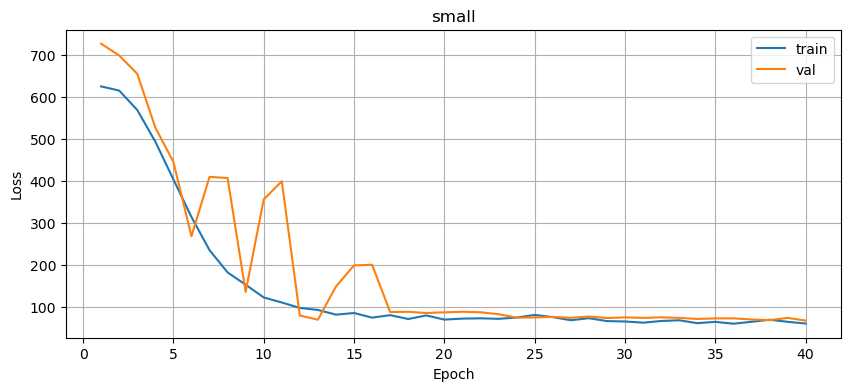

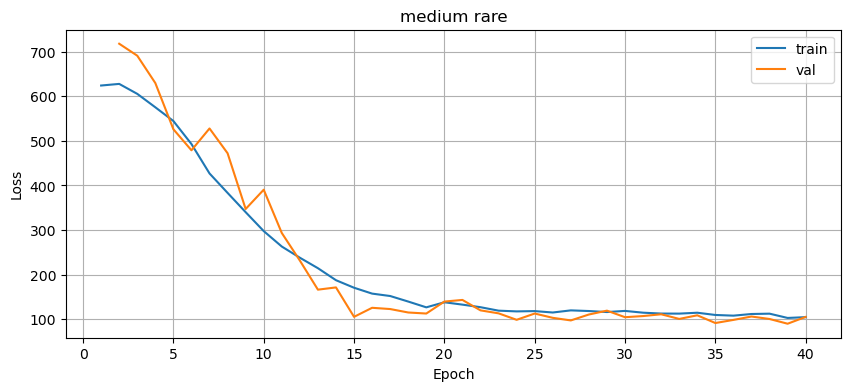

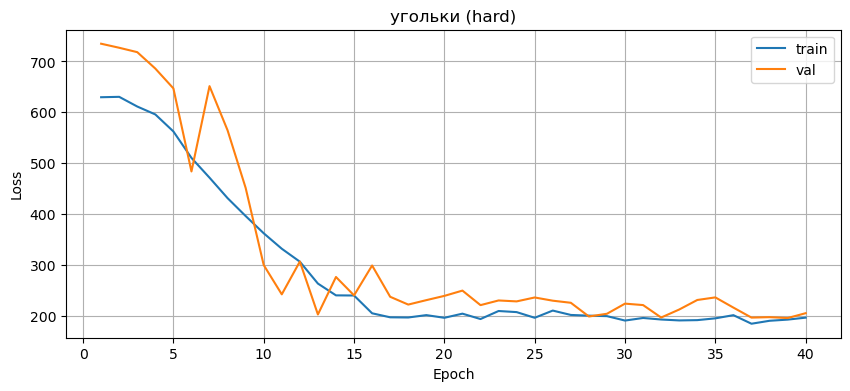

In [152]:
epochs_range = range(1, 41)

plt.figure(figsize=(10,4))
plt.plot(epochs_range, small_train_losses, label='train')
plt.plot(epochs_range, small_val_losses, label='val')

plt.title('small')
plt.xlabel('Epoch')

plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs_range, medium_train_losses, label='train')
plt.plot(epochs_range, medium_val_losses, label='val')
plt.title('medium rare')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs_range, hard_train_losses, label='train')
plt.plot(epochs_range, hard_val_losses, label='val')
plt.title('угольки (hard)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()




In [153]:
criterion = MSECriterion()
def evaluate_model(model, dataloader):

    model.evaluate()
    for X_test, y_test in dataloader:

        with torch.no_grad():  
            predictions = model.updateOutput(X_test)
        metrics = criterion.updateOutput(predictions.data.numpy(), y_test.data.numpy())
    
    return print(f"mse {metrics}")

In [154]:
evaluate_model(small, test_loader)
evaluate_model(medium, test_loader)
evaluate_model(hard, test_loader)

mse 38.02057117622209
mse 118.83198050233106
mse 212.53717010854865


Угольки (модель hard) и впрямь сгорели, по итогам внутрететрадных соревнований трех моделей побеждает "*барабанная дробь*" модель small, ну как говориться маленький, да удаленький. Она может подойти и забрать свой приз **лучшая модель**.

In [155]:
#torch.save(small.getParameters(), 'best_model_torch.pth')